In [3]:
import random
                       
import pandas as pd                       
import matplotlib.pyplot as plt                       
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/mnist_test.csv')
df = pd.read_csv('drive/My Drive/Colab Notebooks/mnist_train.csv')

In [6]:
anom = df[:1000]
clean = df[1000:]

In [7]:
print(anom,'\n','\n')
print(clean)

     label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0        5    0    0    0    0    0    0    0    0    0  ...      0      0   
1        0    0    0    0    0    0    0    0    0    0  ...      0      0   
2        4    0    0    0    0    0    0    0    0    0  ...      0      0   
3        1    0    0    0    0    0    0    0    0    0  ...      0      0   
4        9    0    0    0    0    0    0    0    0    0  ...      0      0   
..     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
995      7    0    0    0    0    0    0    0    0    0  ...      0      0   
996      6    0    0    0    0    0    0    0    0    0  ...      0      0   
997      0    0    0    0    0    0    0    0    0    0  ...      0      0   
998      3    0    0    0    0    0    0    0    0    0  ...      0      0   
999      6    0    0    0    0    0    0    0    0    0  ...      0      0   

     28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0

In [8]:
for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [9]:
anom['label'] = 1
clean['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

 ##        

### **Autoencoder**

In [11]:
import torch.nn as nn

In [12]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

#### **training and predicting** 

In [16]:
import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [13]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

#### **Training**

In [17]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       'drive/My Drive/Colab Notebooks/mnist_train.csv',
                       index_col=False
                       )

In [18]:
# PyTorch DataLoader class:

train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [20]:
# train the model with loop


model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0033507320060084263
Epoch Complete in 0:00:55.952723
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.003247024132311344
Epoch Complete in 0:00:53.677067
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0031346719364325204
Epoch Complete in 0:00:50.847898
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.003008505614846945
Epoch Complete in 0:00:50.520403
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0028771639928221703
Epoch Complete in 0:00:51.660592
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.002758556891232729
Epoch Complete in 0:00:51.360776
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.002675507429863016
Epoch Complete in 0:00:51.108800
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.0026286427102983
Epoch Complete in 0:00:51.176249
-----------------------

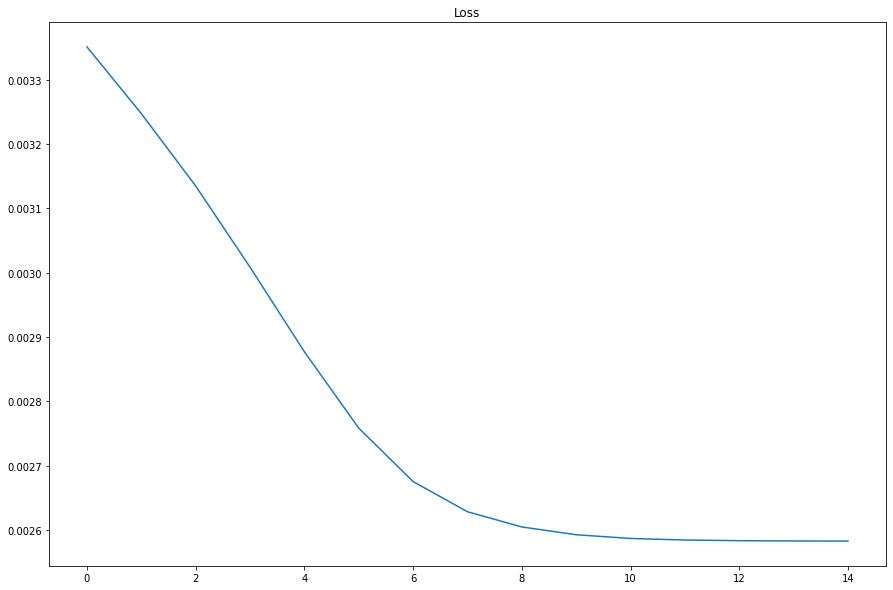

In [21]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

**Prediction**

In [23]:
model.eval()
loss_dist = []
anom = pd.read_csv('anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

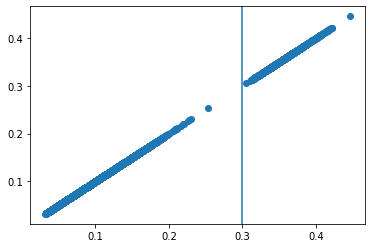

In [24]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


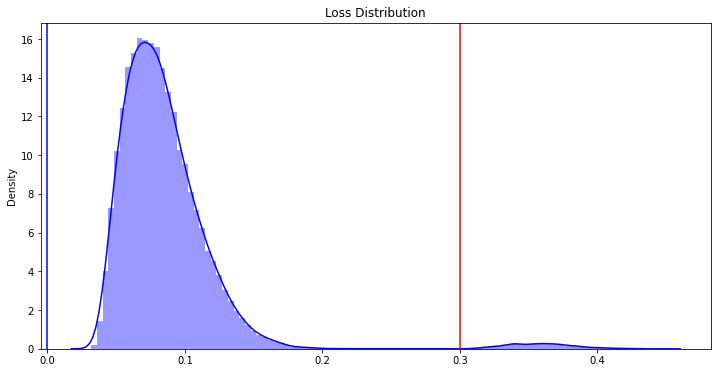

In [25]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [27]:
df = pd.read_csv('anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 59000	[FN] 0


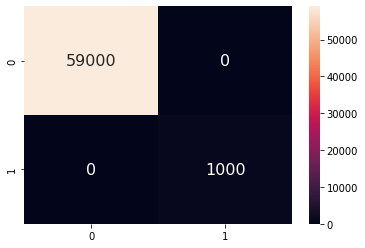

In [28]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')